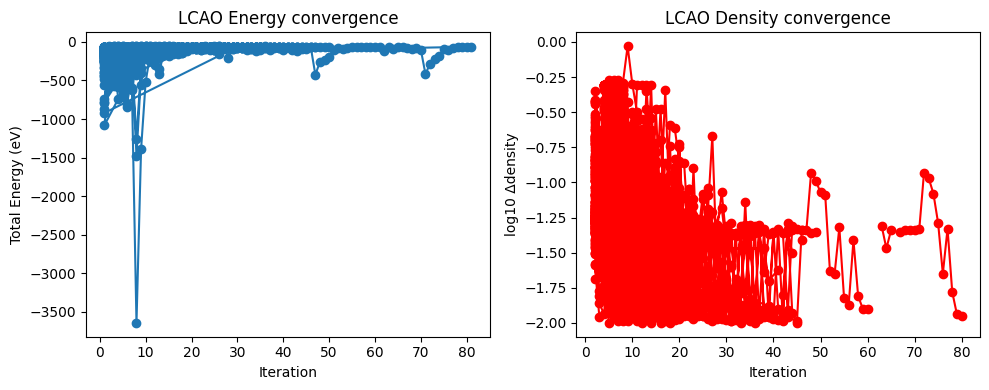

In [21]:
import re
import matplotlib.pyplot as plt

def parse_scf_log(logfile):
    """
    Parse GPAW SCF iteration log for energies and density errors.
    """
    iterations, energies, dens_errors = [], [], []

    with open(logfile, "r") as f:
        for line in f:
            if line.strip().startswith("iter:"):
                parts = line.split()
                try:
                    it = int(parts[1])
                    energy = float(parts[3])
                    dens_err = None
                    for p in parts:
                        try:
                            if re.match(r"^-?\d+\.\d+$", p):  # pick floats
                                pass
                        except:
                            continue
                    # density error is usually the last float in line
                    try:
                        dens_err = float(parts[-1])
                    except:
                        pass

                    iterations.append(it)
                    energies.append(energy)
                    dens_errors.append(dens_err)
                except:
                    continue

    return iterations, energies, dens_errors


def plot_convergence(logfile):
    it, E, dens = parse_scf_log(logfile)

    plt.figure(figsize=(10,4))

    # Energy plot
    plt.subplot(1,2,1)
    plt.plot(it, E, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Total Energy (eV)")
    plt.title("LCAO Energy convergence")

    # Density error plot
    plt.subplot(1,2,2)
    plt.plot(it, dens, marker="o", color="red")
    plt.xlabel("Iteration")
    plt.ylabel("log10 Δdensity")
    plt.title("LCAO Density convergence")

    plt.tight_layout()
    plt.savefig("scf_convergence.png", dpi=300)
    plt.show()


plot_convergence("caf2_cluster_lcao.log")

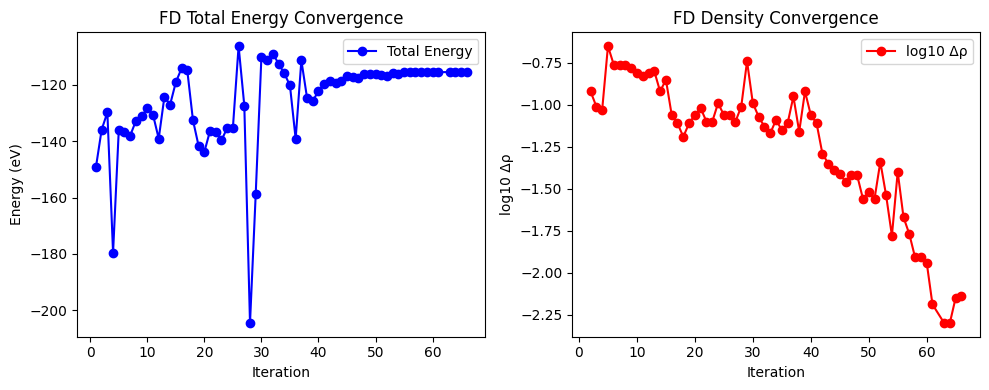

Saved: caf2_fd_convergence.png


In [1]:
import re
import matplotlib.pyplot as plt

def parse_fd_log(logfile):
    """
    Parse GPAW finite-difference SCF iteration log for energies and density errors.
    """
    iterations, energies, dens_errors = [], [], []

    with open(logfile, "r") as f:
        for line in f:
            if line.strip().startswith("iter:"):
                parts = line.split()
                try:
                    it = int(parts[1])
                    energy = float(parts[3])

                    # Find last float in the line (log10 density change)
                    dens_err = None
                    floats = re.findall(r"-?\d+\.\d+", line)
                    if len(floats) >= 2:
                        dens_err = float(floats[-1])

                    iterations.append(it)
                    energies.append(energy)
                    dens_errors.append(dens_err)
                except Exception:
                    continue

    return iterations, energies, dens_errors


def plot_fd_convergence(logfile, prefix="caf2_cluster_fd"):
    it, E, dens = parse_fd_log(logfile)

    plt.figure(figsize=(10, 4))

    # Energy convergence
    plt.subplot(1, 2, 1)
    plt.plot(it, E, marker="o", color="blue", label="Total Energy")
    plt.xlabel("Iteration")
    plt.ylabel("Energy (eV)")
    plt.title("FD Total Energy Convergence")
    plt.legend()

    # Density convergence
    plt.subplot(1, 2, 2)
    plt.plot(it, dens, marker="o", color="red", label="log10 Δρ")
    plt.xlabel("Iteration")
    plt.ylabel("log10 Δρ")
    plt.title("FD Density Convergence")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{prefix}_convergence.png", dpi=300)
    plt.show()

    print(f"Saved: {prefix}_convergence.png")

plot_fd_convergence("caf2_cluster_fd.log", prefix="caf2_fd")

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from ase.io import read
from ase.formula import Formula

# ---------- Configuration ----------
FILES = ["caf2_cluster.xyz", "caf2_er_cluster.xyz"]
CAF_CUTOFF = 2.70  # Å
# -----------------------------------

def pairwise_distances(positions):
    diff = positions[:, None, :] - positions[None, :, :]
    return np.sqrt((diff**2).sum(axis=2))

def dict_sorted(d):
    return {k: d.get(k, 0) for k in sorted(d)}

def analyze_cluster(xyz, caf_cutoff=CAF_CUTOFF):
    atoms = read(xyz)
    pos = atoms.get_positions()
    syms = atoms.get_chemical_symbols()
    counts = Counter(syms)
    formula = Formula.from_dict(counts).format("metal")
    D = pairwise_distances(pos)
    np.fill_diagonal(D, np.nan)

    idx_Ca = [i for i, s in enumerate(syms) if s == "Ca"]
    idx_F  = [i for i, s in enumerate(syms) if s == "F"]
    idx_Er = [i for i, s in enumerate(syms) if s == "Er"]

    caf_dists, erf_dists = [], []

    for i in idx_Ca:
        for j in idx_F:
            if np.isfinite(D[i, j]):
                caf_dists.append(D[i, j])
    for i in idx_Er:
        for j in idx_F:
            if np.isfinite(D[i, j]):
                erf_dists.append(D[i, j])

    def stats(arr):
        if not len(arr): return None
        return dict(
            count=len(arr),
            min=np.min(arr),
            mean=np.mean(arr),
            median=np.median(arr),
            max=np.max(arr),
            std=np.std(arr, ddof=1)
        )

    return {
        "file": xyz,
        "formula": formula,
        "caf": np.array(caf_dists),
        "erf": np.array(erf_dists),
        "caf_stats": stats(caf_dists),
        "erf_stats": stats(erf_dists) if len(erf_dists) else None,
        "counts": counts
    }

def plot_histograms(data_list):
    plt.figure(figsize=(5.8, 3.6), dpi=150)
    colors = ["tab:blue", "tab:green"]

    for i, d in enumerate(data_list):
        label = d["formula"]
        if len(d["caf"]) > 0:
            plt.hist(d["caf"], bins=30, alpha=0.5, color=colors[i],
                     label=f"{label} (Ca–F)")
        if d["erf_stats"]:
            plt.hist(d["erf"], bins=30, alpha=0.5, color="tab:red",
                     label=f"{label} (Er–F)")

    plt.axvline(2.36, color="k", ls="--", lw=1, label="Bulk Ca–F ≈ 2.36 Å")
    plt.xlabel("Bond distance (Å)")
    plt.ylabel("Count")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig("caf2_vs_er_bond_hist.png", dpi=250)
    plt.close()

def main():
    all_data = []
    for f in FILES:
        if os.path.exists(f):
            result = analyze_cluster(f)
            all_data.append(result)
            print(f"\n=== {result['formula']} ===")
            print(f"File: {f}")
            print(f"Elements: {result['counts']}")
            if result["caf_stats"]:
                print("\n-- Ca–F Distance Stats (Å) --")
                for k, v in result["caf_stats"].items():
                    print(f"{k.capitalize():>8}: {v:.3f}" if isinstance(v, float) else f"{k.capitalize()}: {v}")
            if result["erf_stats"]:
                print("\n-- Er–F Distance Stats (Å) --")
                for k, v in result["erf_stats"].items():
                    print(f"{k.capitalize():>8}: {v:.3f}" if isinstance(v, float) else f"{k.capitalize()}: {v}")
        else:
            print(f"File not found: {f}")

    # Comparative plot
    plot_histograms(all_data)
    print("\n Histogram saved → caf2_vs_er_bond_hist.png")

    # Markdown report
    with open("caf2_er_comparison.md", "w") as f:
        f.write("# CaF₂ vs Er–Doped Cluster Bond Analysis\n\n")
        for d in all_data:
            f.write(f"## {d['formula']}\n")
            f.write(f"- **File:** {d['file']}\n")
            f.write(f"- **Elements:** {dict(d['counts'])}\n\n")
            if d["caf_stats"]:
                f.write("### Ca–F Distance Statistics (Å)\n")
                for k, v in d["caf_stats"].items():
                    f.write(f"- {k.capitalize()}: {v:.3f}\n")
            if d["erf_stats"]:
                f.write("\n### Er–F Distance Statistics (Å)\n")
                for k, v in d["erf_stats"].items():
                    f.write(f"- {k.capitalize()}: {v:.3f}\n")
            f.write("\n---\n")
        f.write("![Bond Length Histogram](caf2_vs_er_bond_hist.png)\n")

    print("Markdown report saved → caf2_er_comparison.md")

if __name__ == "__main__":
    main()


=== Ca8F16 ===
File: caf2_cluster.xyz
Elements: Counter({'F': 16, 'Ca': 8})

-- Ca–F Distance Stats (Å) --
Count: 128
     Min: 2.364
    Mean: 6.308
  Median: 5.950
     Max: 16.550
     Std: 3.256

=== Ca7ErF16 ===
File: caf2_er_cluster.xyz
Elements: Counter({'F': 16, 'Ca': 7, 'Er': 1})

-- Ca–F Distance Stats (Å) --
Count: 112
     Min: 2.364
    Mean: 6.475
  Median: 5.950
     Max: 16.550
     Std: 3.339

-- Er–F Distance Stats (Å) --
Count: 16
     Min: 2.364
    Mean: 5.141
  Median: 4.527
     Max: 10.485
     Std: 2.366

 Histogram saved → caf2_vs_er_bond_hist.png
📄 Markdown report saved → caf2_er_comparison.md


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from ase.io import read
from ase.formula import Formula

# ---------- Configuration ----------
FILES = ["caf2_cluster.xyz", "caf2_er_cluster.xyz"]
CAF_CUTOFF = 2.70  # Å
# -----------------------------------

def pairwise_distances(positions):
    diff = positions[:, None, :] - positions[None, :, :]
    return np.sqrt((diff**2).sum(axis=2))

def analyze_cluster(xyz, caf_cutoff=CAF_CUTOFF):
    atoms = read(xyz)
    pos = atoms.get_positions()
    syms = atoms.get_chemical_symbols()
    counts = Counter(syms)
    formula = Formula.from_dict(counts).format("metal")
    D = pairwise_distances(pos)
    np.fill_diagonal(D, np.nan)

    idx_Ca = [i for i, s in enumerate(syms) if s == "Ca"]
    idx_F  = [i for i, s in enumerate(syms) if s == "F"]
    idx_Er = [i for i, s in enumerate(syms) if s == "Er"]

    caf_dists, erf_dists = [], []
    for i in idx_Ca:
        for j in idx_F:
            if np.isfinite(D[i, j]):
                caf_dists.append(D[i, j])
    for i in idx_Er:
        for j in idx_F:
            if np.isfinite(D[i, j]):
                erf_dists.append(D[i, j])

    def stats(arr):
        if not len(arr): return None
        return dict(
            count=len(arr),
            min=np.min(arr),
            mean=np.mean(arr),
            median=np.median(arr),
            max=np.max(arr),
            std=np.std(arr, ddof=1)
        )

    return {
        "file": xyz,
        "formula": formula,
        "caf": np.array(caf_dists),
        "erf": np.array(erf_dists),
        "caf_stats": stats(caf_dists),
        "erf_stats": stats(erf_dists) if len(erf_dists) else None,
        "counts": counts
    }

def plot_histograms(data_list):
    plt.figure(figsize=(6, 3.8), dpi=150)
    colors = ["tab:blue", "tab:green", "tab:orange", "tab:purple"]

    for i, d in enumerate(data_list):
        label = d["formula"]
        if len(d["caf"]) > 0:
            plt.hist(d["caf"], bins=30, alpha=0.45, color=colors[i % len(colors)],
                     label=f"{label} (Ca–F)")
        if d["erf_stats"]:
            plt.hist(d["erf"], bins=30, alpha=0.6, color="tab:red",
                     label=f"{label} (Er–F)")

    plt.axvline(2.36, color="k", ls="--", lw=1, label="Bulk Ca–F ≈ 2.36 Å")
    plt.xlabel("Bond distance (Å)")
    plt.ylabel("Count")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig("caf2_doped_bond_hist.png", dpi=250)
    plt.close()

def main():
    all_data = []
    table_data = []

    for f in FILES:
        if os.path.exists(f):
            result = analyze_cluster(f)
            all_data.append(result)

            caf_mean = result["caf_stats"]["mean"] if result["caf_stats"] else np.nan
            erf_mean = result["erf_stats"]["mean"] if result["erf_stats"] else np.nan
            delta_r  = erf_mean - caf_mean if result["erf_stats"] else 0.0

            table_data.append([result["formula"], caf_mean, erf_mean, delta_r])

            print(f"\n=== {result['formula']} ===")
            print(f"File: {f}")
            print(f"Elements: {result['counts']}")
            if result["caf_stats"]:
                print(f"Mean Ca–F distance : {caf_mean:.3f} Å")
            if result["erf_stats"]:
                print(f"Mean Er–F distance : {erf_mean:.3f} Å")
                print(f"Δr (Er–F − Ca–F)  : {delta_r:.3f} Å")
        else:
            print(f"File not found: {f}")

    plot_histograms(all_data)
    print("\nHistogram saved → caf2_doped_bond_hist.png")

    # Markdown report
    with open("caf2_doped_comparison.md", "w") as f:
        f.write("# CaF₂ vs Er–Doped Cluster Bond Analysis\n\n")
        f.write("| System | Mean Ca–F (Å) | Mean Er–F (Å) | Δr (Å) |\n")
        f.write("|:--------|:---------------:|:---------------:|:-------:|\n")
        for row in table_data:
            sys, caf, erf, dr = row
            caf_s = f"{caf:.3f}" if np.isfinite(caf) else "—"
            erf_s = f"{erf:.3f}" if np.isfinite(erf) else "—"
            dr_s  = f"{dr:+.3f}" if erf_s != "—" else "—"
            f.write(f"| {sys} | {caf_s} | {erf_s} | {dr_s} |\n")

        f.write("\n![Bond Length Histogram](caf2_doped_bond_hist.png)\n")

    print("Markdown report saved → caf2_doped_comparison.md")

if __name__ == "__main__":
    main()


=== Ca8F16 ===
File: caf2_cluster.xyz
Elements: Counter({'F': 16, 'Ca': 8})
Mean Ca–F distance : 6.308 Å

=== Ca7ErF16 ===
File: caf2_er_cluster.xyz
Elements: Counter({'F': 16, 'Ca': 7, 'Er': 1})
Mean Ca–F distance : 6.475 Å
Mean Er–F distance : 5.141 Å
Δr (Er–F − Ca–F)  : -1.334 Å

Histogram saved → caf2_doped_bond_hist.png
Markdown report saved → caf2_doped_comparison.md
